## Summary of the Results

Here I compare the results obtained on the MovieLens dataset using [Xiangnan He et al, 2017](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf) neural collaborative filtering implemented in `Keras` (original paper), `Pytorch` and `Gluon`.

The problem, as framed in the paper, consists in predicting whether a user "interacted" with a movie (1) or not (0) (i.e. ignoring the actual movie rating) using implicit negative feedback. The success metrics are the Hit Ratio (HR) and Normalized Discounted Cumulative Gain (NDCG) at K, with K=10 in this excercise. For more details on the problem formulation I recommend reading the [paper](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf). 

Just emphasize that here I show the results of a few experiments I run (around 70) and it is by no means a thorough exploration of the parameter space. 

In [1]:
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set(style="darkgrid")

from plot_utils import *

warnings.filterwarnings('ignore')
%matplotlib inline

The `results_df` dataframe contains the results of all the experiments I run. These can be found in the `run_net.sh` script. 

In [2]:
results_df = results_df = pd.read_pickle("models/results_df.p")
print(results_df.shape)
results_df.head()

(66, 5)


,modelname,best_hr,best_ndcg,best_iter,train_time
0,keras_GMF_bs_256_reg_00_lr_001_n_emb_8.h5,0.647517,0.368284,19,76.211321
1,keras_GMF_bs_256_reg_00_lr_0005_n_emb_8.h5,0.650662,0.373357,29,76.961639
2,keras_GMF_bs_256_reg_00_lr_0001_n_emb_8.h5,0.650993,0.374349,27,75.853858
3,keras_GMF_bs_512_reg_00_lr_001_n_emb_8.h5,0.648675,0.365255,24,49.306395
4,keras_GMF_bs_512_reg_00_lr_0005_n_emb_8.h5,0.651325,0.371774,27,49.452068


For example, the first row corresponds to the General Matrix Factorization (GMF) architecture, using a batch size of 256, no regularization, a learning rate of 0.01 and 8 dimensions embeddings. 

## GMF Results

The GMF model is rather simple, user and item embeddings multiplied (no bias in the paper's implementation) and "plugged" into an output neuron with a `sigmoid` activation function.  

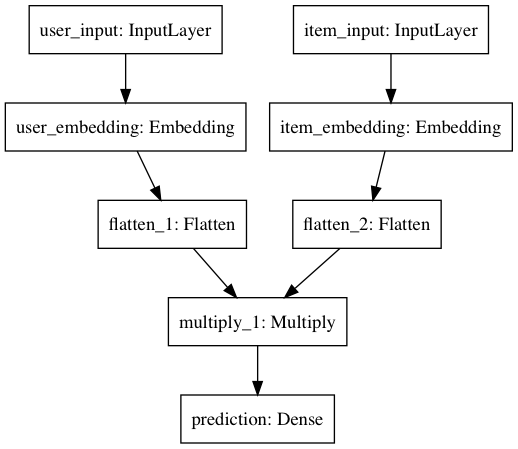

In [3]:
Image(filename = "docs/images/GMF_model.png", width=300)
# This plot will appear to the left of the notebook in github. 
# If you want it to be centered when running the notebook locally create a directory:
# ~/.jupyter/custom
# and in there create a file called custom.css with this in it:
# .output_png {
#     display: table-cell;
#     text-align: center;
#     vertical-align: middle;
# }

In [4]:
df_gmf = GMF_df(results_df)
idxmax = [df_gmf[df_gmf.dl_frame == "keras"].best_hr.idxmax(), 
          df_gmf[df_gmf.dl_frame == "pytorch"].best_hr.idxmax(),
          df_gmf[df_gmf.dl_frame == "gluon"].best_hr.idxmax()]
df_gmf.style.apply(lambda x: ['background: lightgreen' if x.name in idxmax else '' for i in x], axis=1)
# The df here will look "boring" in github. If diplayed locally the rows corresponding to the 
# maximum values of best_hr will be highlighted in lightgreen

,best_hr,best_ndcg,best_iter,dl_frame,n_emb
0,0.655132,0.374491,24,gluon,8
1,0.688742,0.403537,22,gluon,16
2,0.694536,0.41311,29,gluon,32
3,0.693377,0.4117,8,gluon,64
4,0.653808,0.372819,21,keras,8
5,0.693046,0.406408,25,keras,16
6,0.692715,0.410343,13,keras,32
7,0.683609,0.400905,7,keras,64
8,0.651656,0.37725,29,pytorch,8
9,0.687086,0.406592,30,pytorch,16


The first thing to notice is that the `Keras` results are consistent with those in the original paper (see their Figure 4, for the GMF model). The small differences are likely due to the fact that I run 30 epochs, while the authors run 100 (or at least this is the default number included in their repo). In reality, I often find that the model overfits quite early.  In addition we can see that, as expected, the results are consistent between the tree frames. It is worth noting that the best iteration for `Pytorch` using 32 dim embeddings is number 30. This suggest that the model was still learning by that iteration and that a higher number of epochs could lead to a better result.  

## MLP Results

The MLP model is also rather simple. User and Item embeddings, concatenated in a first layer and passed to a series of dense layers. Finally, the final layer is connected to an output neuron with a sigmoid activation (see the paper their Figure 2). 

It is my understanding that in the original paper they use 3 dense layer being the 1st one the result of concatenating the embeddings, as illustrated in the following figure

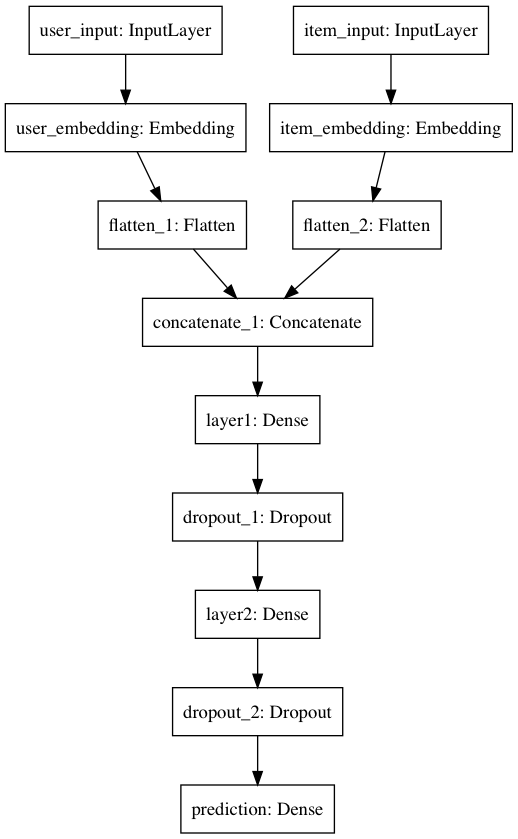

In [5]:
Image(filename = "docs/images/MLP_model.png", width=300)

In [6]:
df_mlp = MLP_df(results_df)
idxmax = [df_mlp[df_mlp.dl_frame == "keras"].best_hr.idxmax(), 
          df_mlp[df_mlp.dl_frame == "pytorch"].best_hr.idxmax(),
          df_mlp[df_mlp.dl_frame == "gluon"].best_hr.idxmax()]
df_mlp.style.apply(lambda x: ['background: lightgreen' if x.name in idxmax else '' for i in x], axis=1)

,best_hr,best_ndcg,best_iter,dl_frame,n_emb,with_dropout
0,0.665894,0.381636,30,gluon,16,wodp
1,0.675331,0.393369,23,gluon,32,wodp
2,0.67649,0.392122,22,gluon,64,wodp
3,0.684934,0.390321,18,gluon,128,wodp
4,0.662086,0.382435,30,keras,16,wodp
5,0.675993,0.396501,26,keras,32,wodp
6,0.684106,0.403377,11,keras,64,wodp
7,0.686755,0.407646,11,keras,128,wodp
8,0.659934,0.378215,21,pytorch,16,wodp
9,0.665728,0.386212,29,pytorch,32,wodp


Before commenting the results in the table let me explain a bit the experiments I run, which are all in the `run_net.sh` script. For the MLP I have used the following layer set ups: `[32, 16, 8], "[64, 32, 16]", [128, 64, 32]` and  `[256, 128, 64]`. This means that the number of embeddings that are concatenated in the first layer are 16, 32, 64 and 128 respectively. One could also try with and without dropout. The best results per number of embeddings and deep learning frame are shown in the table. 

Again, results are consistent between deep learning frames. 

## Neural Collaborative Filtering

Here we combine the two models before as illustrated in the Figure

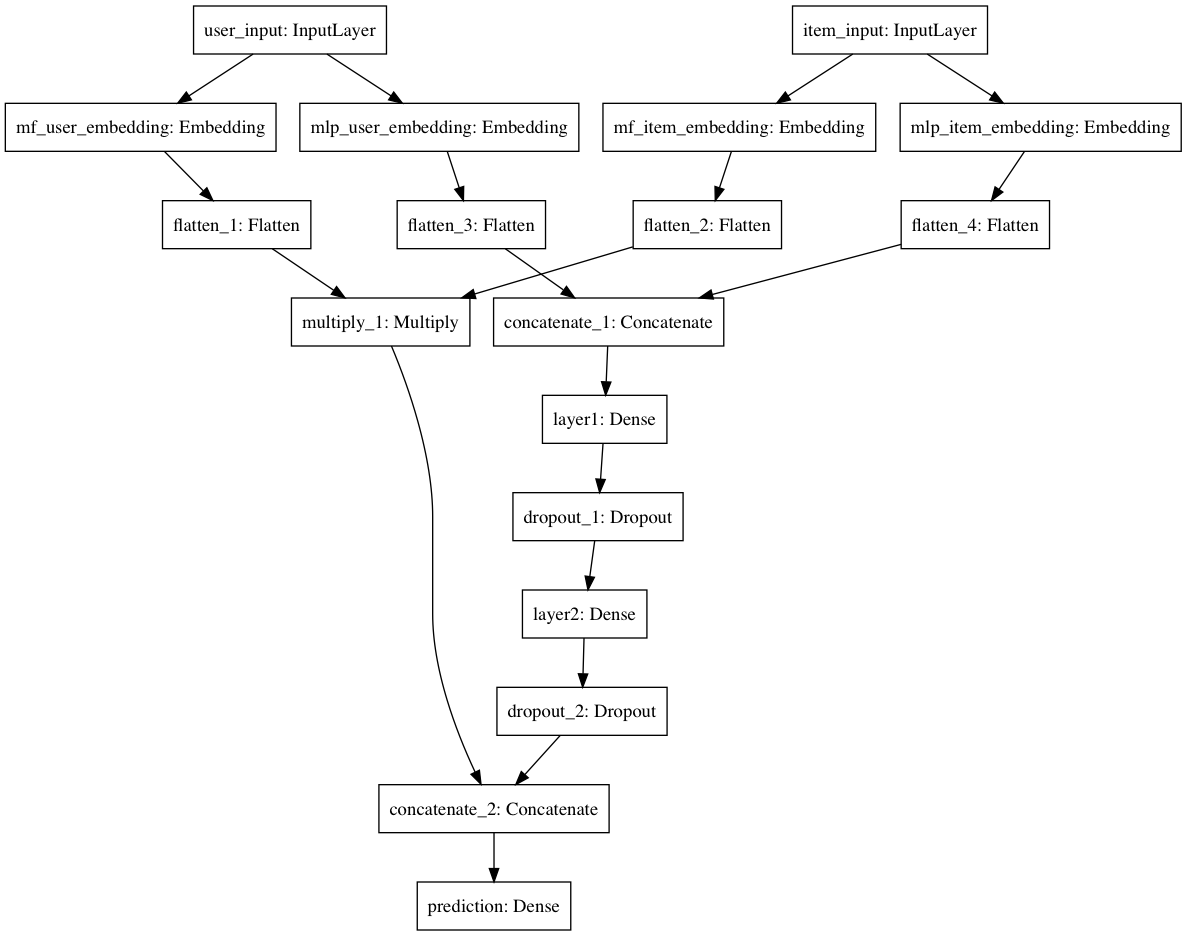

In [7]:
Image(filename = "docs/images/NeuMF_model.png", width=500)

Here I have also tried two set ups: I have tried this architecture with pretrained weights and then re-trained for a small number of epochs and a lower learning rate and freezing the entire architecture but the last dense layer (`concatenate_2` in the figure) then trained only that layer for a small number of epochs and a lower learning rate.

On the other hand, in the paper they explain that: *"After feeding pre-trained parameters into NeuMF, we optimize it with the vanilla SGD, rather than Adam. This is because Adam needs to save momentum information for updating parameters properly. As we initialize NeuMF with pre-trained model parameters only and forgo saving the momentum information, it is unsuitable to further optimize NeuMF with momentum-based methods."* So I only tried `SGD`. 

Again, the experiments run when using the NeuMF model are all included in `run_net.sh`.

In [8]:
df_neumf = NeuMF_df(results_df)
idxmax = [df_neumf[df_neumf.dl_frame == "keras"].best_hr.idxmax(), 
          df_neumf[df_neumf.dl_frame == "pytorch"].best_hr.idxmax(),
          df_neumf[df_neumf.dl_frame == "gluon"].best_hr.idxmax()]
df_neumf.style.apply(lambda x: ['background: lightgreen' if x.name in idxmax else '' for i in x], axis=1)

,best_hr,best_ndcg,best_iter,dl_frame,with_pretrained,last_layer
0,0.707616,0.421801,1,gluon,wpret,trainable
1,0.712583,0.425008,3,gluon,wpret,frozen
2,0.702815,0.419132,2,keras,wpret,trainable
3,0.702815,0.419066,2,keras,wpret,frozen
4,0.708113,0.422094,9,pytorch,wpret,trainable
5,0.710099,0.422915,6,pytorch,wpret,frozen


The results are, overall, consistent with those in the paper, and consistent between deep learning frames.

## METRICS

The figure below shows the results obtained for GMF and MLP using `Gluon`, `Keras` and `Pytorch`.

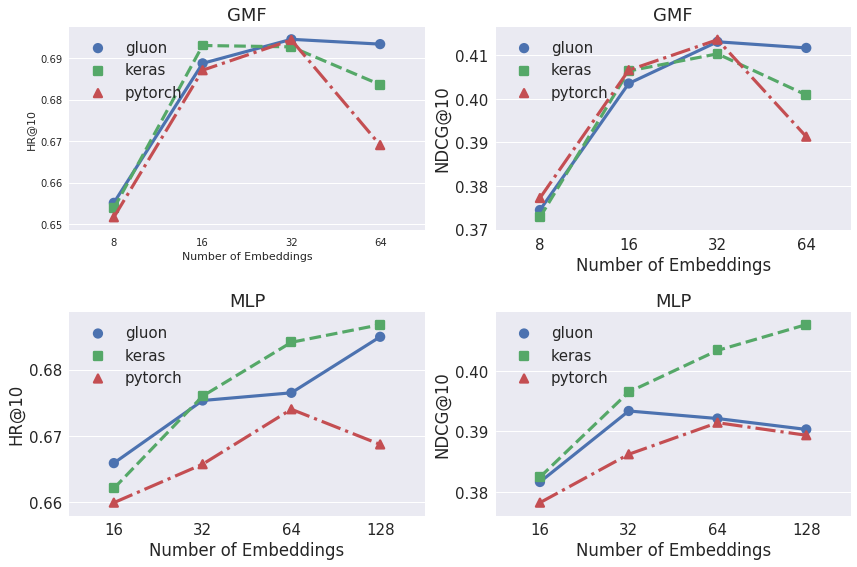

In [9]:
plot_metrics(df_gmf, df_mlp)

## Running Time

leaving aside the performance in terms of HR and NDCG, let's have a look to the running time for each of the 3 frames. 

For `Keras`, the training time is measured as: 

        t1 = time()
        user, item, labels = get_train_instances(train, n_items, n_neg, testNegatives)
        hist = model.fit([user, item], labels, batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
        t2 = time()
        training_time = t2-t1
      
While in the case of `Pytorch` and `Gluon` is measure as:

        t1 = time()
        train(model, criterion, optimizer, epoch, batch_size, use_cuda, # or cxt
            trainRatings,n_items,n_neg,testNegatives)
        t2 = time()
        training_time = t2-t1

Note that the `get_train_instances()` function is run within the `train()` function when using `Pytorch` and `Gluon`. Therefore, the comparison is fair. 

The results are shown below

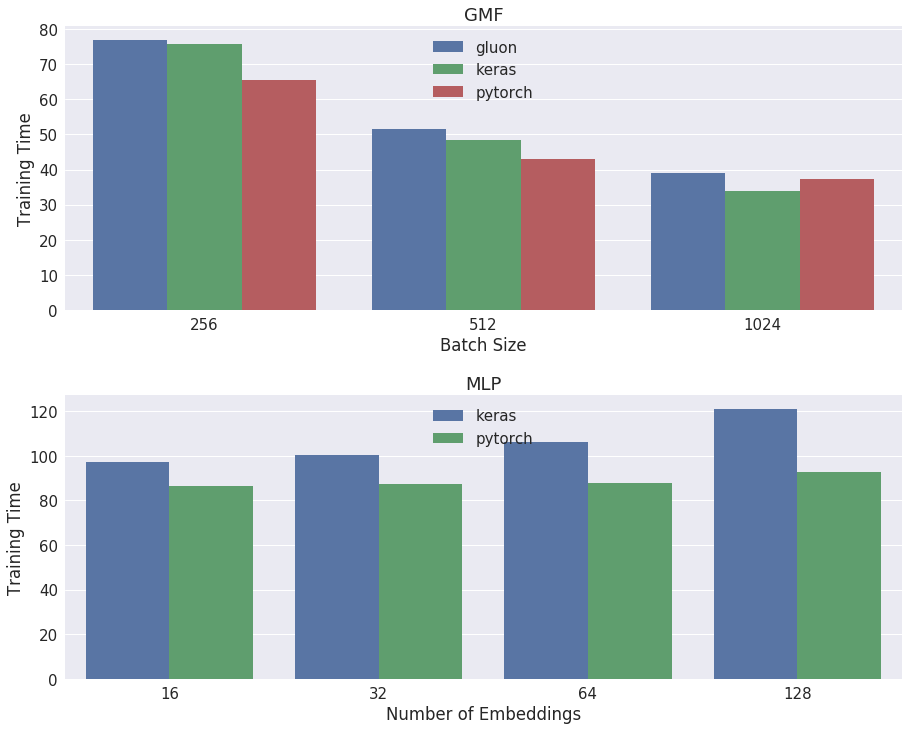

In [10]:
plot_train_time(results_df)

The upper plot shows the training times (seconds) for the GMF model, for `n_emb=8` and different bacth sizes. The lower plot shows the training times (seconds) for the MLP model, for `batch_size=256` and differenr `n_emb` values (16, 32, 64 and 128). Consistent with my previous experiences, `pytorch` is the fastest DL frame.